In [2]:
import os 

os.chdir("/home/hamza-arain/Documents/code/recmmendation")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
df = pd.read_csv("data/online_retail_final.csv")

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Date'] = df['InvoiceDate'].dt.date
df = df[df['Country'] == "France"]


print(df.shape)
df.head(2)

(8468, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0,2010-12-01
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,90.0,2010-12-01


## 1. Time Decay Analysis 

Objective: Understand how recent purchases impact the recommendations.

Analysis:
    Calculate the decay for different timestamps over time to see how quickly the weight diminishes.
    For various time intervals, track how much weight is given to interactions. For instance, if a customer made a purchase 7 days ago, how much weight does it carry compared to a purchase made 30 days ago?

Data Analysis:
    For a sample of users, check the distribution of time decay weights.
    Visualize decay function for different decay factors over time

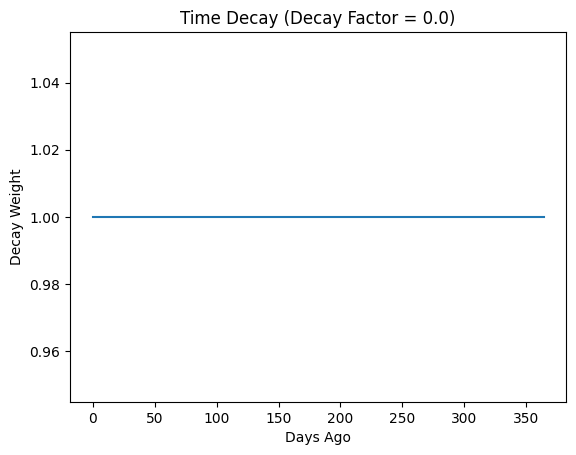

In [5]:
time_range = np.arange(0, 365, 1)  # 1-year time range
decay_factor = 0.0 # Example decay factor
decay_weights = np.exp(-decay_factor * time_range)

plt.plot(time_range, decay_weights)
plt.title(f"Time Decay (Decay Factor = {decay_factor})")
plt.xlabel("Days Ago")
plt.ylabel("Decay Weight")
plt.show()


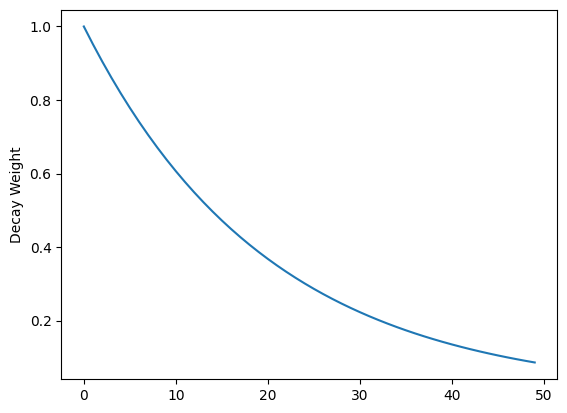

In [6]:
time_range = np.arange(0, 50, 1)  # 1-year time range
decay_factor = 0.05# Example decay factor
decay_weights = np.exp(-decay_factor * time_range)

plt.plot(time_range, decay_weights)

plt.ylabel("Decay Weight")
plt.show()


In [7]:
# Time-decay function
def apply_time_decay(timestamp, current_time, decay_factor=0.8):
    """
    Apply exponential time decay. Recent purchases are given higher weight.
    """
    delta_days = (current_time - timestamp).days
    decay_weight = np.exp(-decay_factor * delta_days)
    return decay_weight



In [8]:
def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    return product_name

## 2. Apriori-based Recommendation Analysis 

In [9]:
import joblib
from mlxtend.frequent_patterns import apriori, association_rules


class AssociationRule:
    def __init__(self, dataframe):
        self.dataframe = dataframe.copy()
        self.rules_path = "output/rules.joblib"
        
        # Check if the rules file exists
        if os.path.exists(self.rules_path):
            self.rules = joblib.load(self.rules_path)
        else:
            self.rules = self.train_rules(min_support=0.07, min_threshold=0.01)

    def outlier_thresholds(self, dataframe, variable):
        quartile1 = dataframe[variable].quantile(0.01)
        quartile3 = dataframe[variable].quantile(0.99)
        interquantile_range = quartile3 - quartile1
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile3 - 1.5 * interquantile_range
        return low_limit, up_limit

    def replace_with_thresholds(self, dataframe, variable):
        low_limit, up_limit = self.outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

    def create_invoice_product_df(self, dataframe, id=False):
        if id:
            return dataframe.groupby(['InvoiceNo', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
                applymap(lambda x: 1 if x > 0 else 0)
        else:
            return dataframe.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0). \
                applymap(lambda x: 1 if x > 0 else 0)


    def preprocessing(self, dataframe):
        dataframe.dropna(inplace=True)
        dataframe = dataframe[~dataframe['InvoiceNo'].str.contains("C", na=False)]
        dataframe = dataframe[~dataframe['StockCode'].str.contains("POST", na=False)]
        dataframe = dataframe[~dataframe['StockCode'].str.contains("C2", na=False)]
        dataframe = dataframe[~dataframe['StockCode'].str.contains("M", na=False)]

        dataframe = dataframe[dataframe['Quantity'] > 0]
        dataframe = dataframe[dataframe['UnitPrice'] > 0]
        self.replace_with_thresholds(dataframe, "Quantity")
        self.replace_with_thresholds(dataframe, "UnitPrice")
        return dataframe

    def encode_units(self, x):
        if x <= 0:
            return 0
        if x >= 1:
            return 1

    def train_rules(self, min_support=0.07, min_threshold=0.01):
        frequency_df = self.dataframe.copy()
        frequency_df = self.preprocessing(frequency_df)

        basket_df = self.create_invoice_product_df(frequency_df, id=True)
        basket_df = basket_df.applymap(self.encode_units)

        frequent_itemsets = apriori(basket_df, min_support=min_support, use_colnames=True)
        rules = association_rules(frequent_itemsets,
                                metric="lift",
                                min_threshold=min_threshold,
                                num_itemsets=len(frequent_itemsets))
        rules = rules.sort_values("lift", ascending=False)

        joblib.dump(rules , self.rules_path)
        return rules

    def recommend(self, product_id, support=0.05, confidence=0.1, lift=5):
        sorted_rules = self.rules[(self.rules["support"]>=support) & (self.rules["confidence"]>=confidence) & (self.rules["lift"]>lift)].sort_values("confidence", ascending=False)

        recommendation_list = []
        for i, product in enumerate(sorted_rules["antecedents"]):
            for j in list(product):
                if j == product_id:
                    recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])
        return list(set(recommendation_list))



In [10]:
ar = AssociationRule(dataframe=df)

stock_code  = "22728"
print(f"Selected Item: {check_id(df, stock_code)[0]}")

recommendations = ar.recommend(stock_code)

for recomended in recommendations:
    print(f"Recommended Item: {check_id(df, recomended)[0]}")


Selected Item: ALARM CLOCK BAKELIKE PINK
Recommended Item: ALARM CLOCK BAKELIKE GREEN
Recommended Item: ALARM CLOCK BAKELIKE RED 


## 3. User-Based Collaborative Filtering Analysis 

In [11]:
user_item_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
user_item_matrix

StockCode,10002,10120,10125,10135,11001,15036,15039,15044C,15056BL,15056N,...,90030C,90031,90099,90184B,90184C,90201B,90201C,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12413.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
12437.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.866667
12441.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
12488.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000
12489.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12734.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12735.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000
12736.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000


In [12]:
# Define User-based recommendation function
def recommend_items_based_on_users(user, df, current_time, top_n=5, time_decay=0):
    """
    User-based collaborative filtering recommendations with time decay.
    """
    if user not in user_item_matrix.index:
        return []  # Cold start user
    
    user_vector = user_item_matrix.loc[user].values.reshape(1, -1)
    similarities = cosine_similarity(user_vector, user_item_matrix)[0]
    
    # Apply time decay to user interactions (recent purchases have higher weight)
    time_weights = np.array([apply_time_decay(df[df['CustomerID'] == user]['InvoiceDate'].max(), current_time) 
                             for _ in range(len(similarities))])
    similarities = similarities * time_weights  # Adjust similarity by time decay
    
    similar_users = user_item_matrix.index[np.argsort(-similarities)[1:top_n+1]]
    recommended_items = user_item_matrix.loc[similar_users].sum().sort_values(ascending=False).index
    return list(recommended_items[:top_n])

user_id = 12735  
current_time = pd.to_datetime("2024-12-01")

recommendations = recommend_items_based_on_users(user_id, df, current_time, top_n=5, time_decay=1)
for recomended in recommendations:
    print(f"Recommended Item: {check_id(df, recomended)[0]}")


Recommended Item: RABBIT NIGHT LIGHT
Recommended Item: MINI PAINT SET VINTAGE 
Recommended Item: SET/6 RED SPOTTY PAPER CUPS
Recommended Item: SET/6 RED SPOTTY PAPER PLATES
Recommended Item: TEA PARTY BIRTHDAY CARD


## 4. Content-Based Recommendation Analysis 

In [13]:
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

class ContentBasedRecommedationSystem:
    def __init__(self, dataframe, model_name='all-MiniLM-L6-v2', embeds_path="output/content_embeddings.joblib", description_path="output/content_descriptions.joblib"):
        self.model = self.load_model(model_name)
        self.dataframe = dataframe.copy()

        self.embeds_path = embeds_path    
        self.description_path = description_path
        if os.path.exists(self.embeds_path) and os.path.exists(self.description_path):
            self.descriptions, self.embeds = joblib.load(self.description_path), joblib.load(self.embeds_path) 
        else:
            self.descriptions, self.embeds = self.train_embeddings()


    def load_model(self, model_name):
        embedding_model = SentenceTransformer(model_name)  
        return embedding_model

    def train_embeddings(self):
        descriptions = self.dataframe.drop_duplicates('StockCode').set_index('StockCode')['Description'].fillna("")
        description_texts = descriptions.tolist()
        embeddings = self.model .encode(description_texts, convert_to_tensor=True)
        
        joblib.dump(embeddings, self.embeds_path)
        joblib.dump(descriptions, self.description_path)
        return descriptions, embeddings

    def recommend(self, item, top_n):
        item_index = self.descriptions.index.get_loc(item) if item in self.descriptions.index else None
        if item_index is None:
            return []  # If item description is missing

        # Get the embedding for the target item
        item_embedding = self.embeds[item_index]
        

        # Compute cosine similarities
        similarities = cosine_similarity([item_embedding], self.embeds)[0]

        # Get the indices of the top N most similar items
        top_indices = np.argsort(-similarities)[1:top_n + 1]
        similar_items = self.descriptions.index[top_indices]
        return list(similar_items)


cbrs = ContentBasedRecommedationSystem(dataframe=df)

# Example usage
item = "15039"

print(f"Selected Item: {check_id(df, item)[0]}")

recommendations = cbrs.recommend(item, top_n=5)
for recommended in recommendations:
    print(f"Recommended Item: {check_id(df, recommended)[0]}")


Selected Item: SANDALWOOD FAN
Recommended Item: MULTICOLOUR HONEYCOMB FAN
Recommended Item: PINK  HONEYCOMB PAPER FAN
Recommended Item: FELTCRAFT CUSHION OWL
Recommended Item: ASSORTED COLOURS SILK FAN
Recommended Item: JUMBO BAG OWLS


## 5. Item-Based Collaborative Filtering Analysis 

In [14]:
recent_data = df[df['InvoiceDate'] >= (df['InvoiceDate'].max() - pd.Timedelta(days=30))]
co_occurrence_matrix = recent_data.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', fill_value=0).T.dot(recent_data.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', fill_value=0))
item_idx = co_occurrence_matrix.index.get_loc(item) if item in co_occurrence_matrix.index else None
item_idx

In [15]:
# Define Item-based recommendation function
def recommend_items_based_on_items(item, df, top_n=5):
    """
    Item-based collaborative filtering using time-sensitive co-occurrence matrix.
    """
    # Create a time-aware co-occurrence matrix by considering only recent data
    recent_data = df[df['InvoiceDate'] >= (df['InvoiceDate'].max() - pd.Timedelta(days=30))]
    co_occurrence_matrix = df.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', fill_value=0).T.dot(df.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', fill_value=0))
    
    item_idx = co_occurrence_matrix.index.get_loc(item) if item in co_occurrence_matrix.index else None
    
    if item_idx is None:
        return []  # If item is not in the matrix
    
    similar_items = co_occurrence_matrix.iloc[item_idx].sort_values(ascending=False).index[1:top_n+1]
    return list(similar_items)

# Example usage
stock_code  = "15039"
print(f"Selected Item: {check_id(df, stock_code)[0]}")

recommendations = recommend_items_based_on_items(stock_code, df, top_n=5)
for recommended in recommendations:
    print(f"Recommended Item: {check_id(df, recommended)[0]}")
    

Selected Item: SANDALWOOD FAN


## 6. Item Rarity Boost Analysis

In [16]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,90.00,2010-12-01
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,90.00,2010-12-01
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,45.00,2010-12-01
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France,10.20,2010-12-01
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France,15.60,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
404085,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-09
404086,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09
404087,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09
404088,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09


In [17]:
# Define item rarity boost considering recent purchases (time-series boost)
def calculate_item_boost(item, df, recent_days=30):
    """
    Boost score for items with low purchase frequency in recent time.
    """
    recent_data = df[df['InvoiceDate'] >= (df['InvoiceDate'].max() - pd.Timedelta(days=recent_days))]
    item_purchases = recent_data['StockCode'].value_counts()
    total_purchases = len(recent_data)
    boost = (total_purchases - item_purchases.get(item, 0)) / total_purchases
    return boost

# Example usage
item = "15039"
calculate_item_boost(item, df, recent_days=30)

1.0

## 7. Hybrid Recommendation Analysis (Weighted Hybrid)

In [116]:
# Weighted Hybrid Recommendation with Time-Series Adjustment
def weighted_hybrid_recommendations(user, item, df, current_time, top_n=5):
    # Define base weights for each methodrecommendations
    base_weights = {
        "apriori": 0.4,
        "user": 0.3,
        "content": 0.2,
        "item": 0.1
    }

    # Check if the user is new
    is_new_user = user not in user_item_matrix.index

    # Adjust weights dynamically
    if is_new_user:
        base_weights['content'] += 0.2  # Favor content for new users
        base_weights['item'] += 0.1  # Favor content for new users
        base_weights['user'] = 0.0     # Ignore user-based recommendations for new users

    # Get recommendations from each method
    # apriori_based = recommend_items_based_on_apriori(item, df, top_n * 2)
    apriori_based = ar.recommend(stock_code)
    user_based = [] if is_new_user else rrecommend_items_based_on_users(user, df, current_time, top_n=top_n*2,time_decay=0)
    # content_based = recommend_items_based_on_content(item, df, top_n * 2)
    content_based = cbrs.recommend(item, top_n=top_n * 2)
    item_based = recommend_items_based_on_items(item, df, top_n * 2)

    # Combine recommendations with weighted scores
    scores = {}
    for rank, recommendation in enumerate(apriori_based, start=1):
        scores[recommendation] = scores.get(recommendation, 0) + base_weights['apriori'] / rank
    for rank, recommendation in enumerate(user_based, start=1):
        scores[recommendation] = scores.get(recommendation, 0) + base_weights['user'] / rank
    for rank, recommendation in enumerate(content_based, start=1):
        scores[recommendation] = scores.get(recommendation, 0) + base_weights['content'] / rank
    for rank, recommendation in enumerate(item_based, start=1):
        scores[recommendation] = scores.get(recommendation, 0) + base_weights['item'] / rank


    # Apply boost for less frequent items in recent data
    for recommendation in scores.keys():
        scores[recommendation] += calculate_item_boost(recommendation, df)

    # Sort items by their final weighted scores
    sorted_recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    # Return the top_n recommendations
    return [item[0] for item in sorted_recommendations[:top_n]]


In [117]:
user_item_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)

# Example Usage
user_id = 12345  # Replace with actual user
item_code = '85123A'  # Replace with actual item
current_time = pd.to_datetime("2024-12-01")  # Current date (for time-decay)

print(f"Selected Item: {check_id(df, item_code)[0]}")

recommendations = weighted_hybrid_recommendations(user_id, item_code, df, current_time, top_n=5)

for recomended in recommendations:
    print(f"Recommended Item: {check_id(df, recomended)}")


Selected Item: WHITE HANGING HEART T-LIGHT HOLDER
Recommended Item: ['RED HANGING HEART T-LIGHT HOLDER']
Recommended Item: ['HANGING HEART ZINC T-LIGHT HOLDER']
Recommended Item: ['HANGING HEART JAR T-LIGHT HOLDER']
Recommended Item: ['T-LIGHT HOLDER HANGING LOVE BIRD']
Recommended Item: ['HANGING  BUTTERFLY T-LIGHT HOLDER']
